## Analyse wind

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib notebook

In [3]:
# Output of simulation

# Idealized data
ds_ideal1 = xr.open_dataset('../../../../out/idealized_1712_1812/FIONA_idealized-3D_DOM01_ML_0001.nc')
ds_ideal2 = xr.open_dataset('../../../../out/idealized_1712_1812/FIONA_idealized-3D_DOM01_ML_0002.nc')

# reference data
ds_ref1 = xr.open_dataset('../../../../out/reference_1712_1812/FIONA-3D_DOM01_ML_0001.nc')
ds_ref2 = xr.open_dataset('../../../../out/reference_1712_1812/FIONA-3D_DOM01_ML_0001.nc')

In [4]:
lon = ds_ideal1.lon.values
lat = ds_ideal1.lat.values

# Create x and y array from those
x = np.empty(len(lon)*len(lat))
y = np.empty(len(lon)*len(lat))

i = 0
while i < len(x):
    x[i:i+len(lon)] = lon
    i += len(lon)
    
i = 0
c = 0
while i < len(y):
    
    y[i:i+len(lon)] = lat[c]
    
    c += 1
    i += len(lon)

In [60]:
# Center
#center_ideal = np.load('../Data/center_fiona_idealized.npy')

center_ideal1 = np.load('../Data/tmp_center_1to33.npy')
center_ideal2 = np.load('../Data/tmp_center_33toend.npy')

center_ideal = np.concatenate((center_ideal1[0:33], center_ideal2[33:]))

In [6]:
# number of timesteps
ntime1 = len(ds_ideal1.time)
ntime2 = len(ds_ideal2.time)

# number of levels
nlev = len(ds_ideal1.height)
# Last level of center
last_lev = len(center_ideal[0])

# Create u_r and u_phi array of same shape
u_r_ideal_array = np.empty((ntime1+ntime2, len(lon)*len(lat))) 
u_phi_ideal_array = np.empty((ntime1+ntime2, len(lon)*len(lat)))


#### Single level analysis
For simplicitiy only a single level is chosen here.

In [65]:
# Select single level (here 3910m)
ds_ideal1.z_ifc[60,0,0]

# single level center
center_lev = len(center_ideal)-30
center_1lev = center_ideal[:,center_lev,:]

u_ideal1 = ds_ideal1.u[:,60,:]
v_ideal1 = ds_ideal1.v[:,60,:]

u_ideal2 = ds_ideal2.u[:,60,:]
v_ideal2 = ds_ideal2.v[:,60,:]

In [44]:
#reformat u and v
u_ideal_array1 = u_ideal1.values.reshape((ntime1, len(lon)*len(lat)))
v_ideal_array1 = v_ideal1.values.reshape((ntime1, len(lon)*len(lat)))

u_ideal_array2 = u_ideal2.values.reshape((ntime2, len(lon)*len(lat)))
v_ideal_array2 = v_ideal2.values.reshape((ntime2, len(lon)*len(lat)))

In [66]:
for t in range(0,ntime1+ntime2):
    center_1ts = center_1lev[t]
    
    # Create polar coordinate grid (in radians)
    x0 = center_1ts[0]
    y0 = center_1ts[1]
    
    #r = np.sqrt((x-x0)**2 + (y-y0)**2)
    phi = np.arctan2((y-y0), (x-x0))

    # unit vectors
    e_r = np.array([np.cos(phi), np.sin(phi)])
    e_phi= np.array([-np.sin(phi), np.cos(phi)])
    
    if t < ntime2:
        u_r_ideal_array[t,:]   = e_r[0]*u_ideal_array1[t] + e_r[1]*v_ideal_array1[t]
        u_phi_ideal_array[t,:] = e_phi[0]*u_ideal_array1[t] + e_phi[1]*v_ideal_array1[t]
    else:
        t2 = t-ntime1
        u_r_ideal_array[t,:]   = e_r[0]*u_ideal_array2[t2] + e_r[1]*v_ideal_array2[t2]
        u_phi_ideal_array[t,:] = e_phi[0]*u_ideal_array2[t2] + e_phi[1]*v_ideal_array2[t2]

In [10]:
# reshape to grid mapping
u_phi_ideal = u_phi_ideal_array.reshape((ntime1+ntime2, len(lat), len(lon)))
u_r_ideal = u_r_ideal_array.reshape((ntime1+ntime2, len(lat), len(lon)))



<IPython.core.display.Javascript object>


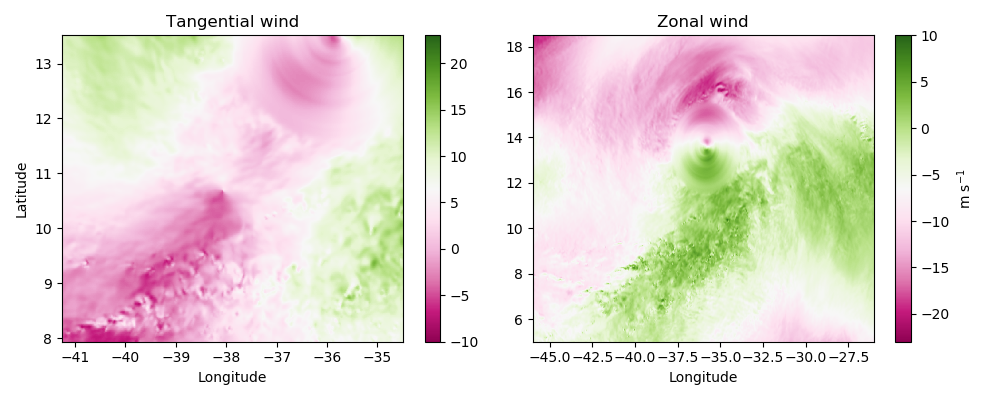

In [145]:
# plot tangential wind vs u

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
cmesh = plt.pcolormesh(lon,lat, u_phi_ideal[0], cmap="PiYG", vmin=-10, vmax=23)
cbar = plt.colorbar(cmesh, ax=ax)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Tangential wind')

ax = fig.add_subplot(122)
cmesh = plt.pcolormesh(lon,lat, u_ideal1[0], cmap="PiYG", vmin=-23, vmax=10)
cbar = plt.colorbar(cmesh, ax=ax)
cbar.ax.set_ylabel(r'm s$^{-1}$')
plt.xlabel('Longitude')
plt.title('Zonal wind')

plt.tight_layout()

### Maximum tangential wind

In [148]:
# Select the cyclone region
# Extract box to save time

t = 0

dist = np.empty((ntime1+ntime2, len(lat), len(lon)))
len_time =  ntime1+ntime2
len_time=1
for t in range(0,len_time):
    c=0
    for lon_i in range(len(lon)):
        for lat_i in range(len(lat)):
            dist[t,lat_i, lon_i] = np.sqrt((lon[lon_i] -center_1lev[t,0])**2 \
                  + (lat[lat_i] - center_1lev[t,1])**2)
            c += 1


In [150]:

time = np.concatenate((ds_ideal1.time.values , ds_ideal2.time.values))

dist.shape, u_phi_ideal.shape, center_1lev

((49, 1126, 1112), (49, 1126, 1112), array([[-38.06200027,  10.68799973],
        [-38.06200027,  10.61600018],
        [-38.06200027,  10.64000034],
        [-38.08000183,  10.62800026],
        [-38.08000183,  10.65200043],
        [-38.08000183,  10.65200043],
        [-38.06200027,  10.66399956],
        [-38.08000183,  10.66399956],
        [-38.08000183,  10.67599964],
        [-38.06200027,  10.67599964],
        [-38.06200027,  10.67599964],
        [-38.06200027,  10.66399956],
        [-38.08000183,  10.67599964],
        [-38.08000183,  10.67599964],
        [-38.08000183,  10.66399956],
        [-38.08000183,  10.66399956],
        [-38.08000183,  10.67599964],
        [-38.08000183,  10.67599964],
        [-38.09799957,  10.68799973],
        [-38.09799957,  10.68799973],
        [-38.11600113,  10.69999981],
        [-38.09799957,  10.71199989],
        [-38.11600113,  10.74800014],
        [-38.09799957,  10.7840004 ],
        [-38.08000183,  10.7840004 ],
        [-38.0

In [138]:
# radius to cut off:
r = 250*180 / (np.pi * 6371)

u_phi_ds = xr.Dataset({'u_phi': (['time', 'lat' , 'lon'],u_phi_ideal), 
            'dist': (['time', 'lat', 'lon'], dist)}, coords = {'lon': lon, 'lat':lat, 'time': time})
u_phi_ds = u_phi_ds.where(u_phi_ds['dist'] <= r, drop = True)

<IPython.core.display.Javascript object>


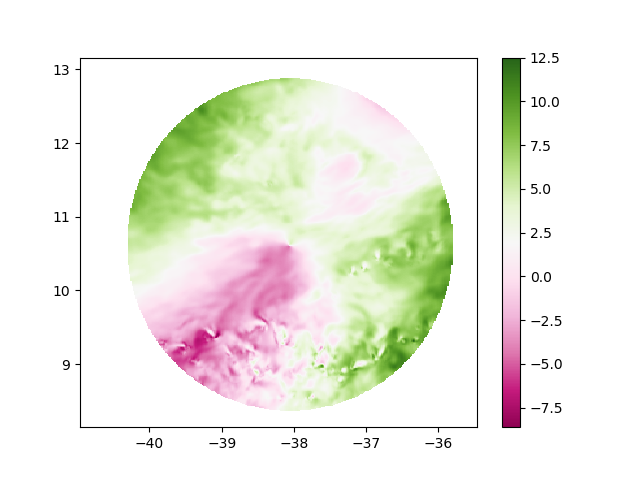

In [147]:
plt.figure()
plt.pcolormesh( u_phi_ds.lon, u_phi_ds.lat, u_phi_ds.u_phi.isel(time=1), cmap = 'PiYG')
plt.colorbar()

In [ ]:
lon.shape